In [1]:
import requests
import pytz
import datetime
import numpy as np
import re
import editdistance
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.misc import imread
import matplotlib.image as mpimg
import requests
import math
import os
import io
from nltk.tokenize import sent_tokenize
import warnings
import pickle

warnings.filterwarnings("ignore")
import matplotlib as mpl
mpl.rcParams['grid.linestyle'] = ':'

%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# **Анализ закрытия метро СПб за 2018 год**

**Вопросы те же, что и в прошлом году:**

* как часто закрывались в прошлом году какие станции?
* на сколько минут какая?
* сколько между закрытием и постом в телеграме
* максимальное количество закрытых за день?

## Mining

Клиент для Телеграма, который позволяет выгружать историю и ключи к API:

In [ ]:
from telethon import TelegramClient
# https://github.com/LonamiWebs/Telethon

# These example values won't work. You must get your own api_id and
# api_hash from https://my.telegram.org, under API Development.
api_id = 107415
api_hash = '30f9d912c13f82700fd844'
phone = '+79215228367'

Теперь приходится использовать SOCKS прокси и старую версию клиента, чтобы подключиться:

In [2]:
import telethon
print(telethon.__version__)

0.19.1.6


In [3]:
from telethon import TelegramClient
import socks
# https://github.com/LonamiWebs/Telethon

client = TelegramClient('session_name_closed', api_id, api_hash, proxy=(socks.SOCKS4, '80.94.22.55', 4145))
client.connect()

True

Код для авторизации:

In [5]:
client.send_code_request(phone)

In [6]:
# If you already have a previous 'session_name.session' file, skip this.
me = client.sign_in(code=39006)  # Put whatever code you received here.

In [7]:
client.is_user_authorized()

True

Загружаем из канала сообщения:

In [24]:
orig_messages = client.get_message_history('@spbmetro', limit=None)
len(orig_messages)

2102

In [2]:
user_timezone = pytz.timezone('Europe/Moscow')

In [27]:
for i in range(1005, 1020):
    msg = orig_messages[-i]
    print(pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S") + ' ' + msg.message)

2017-12-28 14:41:08 В 14-27 ст. Старая деревня закрыта из-за бесхозного предмета
2017-12-28 15:46:57 В 14-44 ст. Старая деревня открыта. Опасных предметов не обнаружено
2017-12-28 16:51:24 В 16-33 ст. Пушкинская закрыта из-за бесхозного предмета
2017-12-28 17:05:36 В 17-03 ст. Пушкинская открыта. Опасных предметов не обнаружено
2017-12-28 17:22:03 В 17-18 вестибюль 1 ст. Спортивная закрыт из-за бесхозного предмета
2017-12-28 17:44:45 В 17-34 ст. Невский проспект и переход на ст. Гостиный двор закрыты из-за бесхозного предмета
2017-12-28 17:49:26 В 17-47 ст. Невский проспект и переход на ст. Гостиный двор открыты. Опасных предметов не обнаружено
2017-12-28 18:01:46 В 17-56 вестибюль 2 ст. Площадь Восстания закрыт на вход, все эскалаторы работают на выход из-за высокого пассажиропотока
2017-12-28 18:05:22 В 18-03 ст. Спортивная открыта. Опасных предметов не обнаружено
2017-12-28 18:12:36 Вестибюль 2 ст. Площадь Восстания работает в режиме регулируемого пассажиропотока. Вестибюль 1 работа

Сохраним их (оригинальный список не сохраняется, поэтому просто перегоним в самописный класс):

In [3]:
class Msg():
    def __init__(self, msg):
        self.date = msg.date
        self.message = msg.message
        self.views = msg.views

In [44]:
data = []
for i in range(3, len(orig_messages)): #because 2 are not Messages
    msg = orig_messages[-i]
    data.append(Msg(msg))

with open('./data/data_till_2019.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open('./data/data_till_2019.pickle', 'rb') as handle:
    orig_messages = pickle.load(handle)

За 2018 год:

In [5]:
dates = np.array([l.date.date() for l in orig_messages])
y2018 = np.where((dates >= datetime.date(2018, 1, 1)) & (dates < datetime.date(2019, 1, 1)))
messages = orig_messages[y2018[0][0] : y2018[0][-1]]
print(len(messages))

1049


In [6]:
corpora = [msg.message for msg in messages]
dates = [pytz.utc.localize(msg.date).astimezone(user_timezone) for msg in messages]

In [7]:
#read metro stations list
stations = []
f = open('stations.txt', 'r')
for line in f.readlines():
    stations.append(line.replace('\n', ''))
print(len(stations))

69


In [8]:
print(stations)

['Автово', 'Адмиралтейская', 'Академическая', 'Балтийская', 'Бухарестская', 'Василеостровская', 'Владимирская', 'Волковская', 'Выборгская', 'Горьковская', 'Гостиный двор', 'Гражданский проспект', 'Девяткино', 'Достоевская', 'Елизаровская', 'Звёздная', 'Звенигородская', 'Кировский завод', 'Комендантский проспект', 'Крестовский остров', 'Купчино', 'Ладожская', 'Ленинский проспект', 'Лесная', 'Лиговский проспект', 'Ломоносовская', 'Маяковская', 'Международная', 'Московская', 'Московские ворота', 'Нарвская', 'Невский проспект', 'Новочеркасская', 'Обводный канал', 'Обухово', 'Озерки', 'Парк Победы', 'Парнас', 'Петроградская', 'Пионерская', 'Площадь Александра Невского 1', 'Площадь Александра Невского 2', 'Площадь Восстания', 'Площадь Ленина', 'Площадь Мужества', 'Политехническая', 'Приморская', 'Пролетарская', 'Проспект Большевиков', 'Проспект Ветеранов', 'Проспект Просвещения', 'Пушкинская', 'Рыбацкое', 'Садовая', 'Сенная площадь', 'Спасская', 'Спортивная', 'Старая Деревня', 'Технологическ

Искать будем по сигнатурам:

In [9]:
signatures = [' '.join([w[:6] for w in l.lower().split(' ') ]) for l in stations]
len(set(signatures))

69

In [10]:
print(signatures)

['автово', 'адмира', 'академ', 'балтий', 'бухаре', 'василе', 'владим', 'волков', 'выборг', 'горько', 'гостин двор', 'гражда проспе', 'девятк', 'достое', 'елизар', 'звёздн', 'звениг', 'кировс завод', 'коменд проспе', 'кресто остров', 'купчин', 'ладожс', 'ленинс проспе', 'лесная', 'лиговс проспе', 'ломоно', 'маяков', 'междун', 'москов', 'москов ворота', 'нарвск', 'невски проспе', 'новоче', 'обводн канал', 'обухов', 'озерки', 'парк победы', 'парнас', 'петрог', 'пионер', 'площад алекса невско 1', 'площад алекса невско 2', 'площад восста', 'площад ленина', 'площад мужест', 'полите', 'примор', 'пролет', 'проспе больше', 'проспе ветера', 'проспе просве', 'пушкин', 'рыбацк', 'садова', 'сенная площад', 'спасск', 'спорти', 'старая деревн', 'технол инстит 1', 'технол инстит 2', 'удельн', 'улица дыбенк', 'фрунзе', 'чёрная речка', 'черныш', 'чкалов', 'электр', 'новокр', 'бегова']


In [11]:
another_signatures = {}
for station in stations:
    if 'проспект' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('проспект', 'пр.').split(' ')])
    if 'площадь' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('площадь', 'пл.').split(' ')])
    if 'ё' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('ё', 'е').split(' ')])
    if 'улица ' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('улица ', '').split(' ')])
    if 'институт' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('институт', 'ин т').split(' ')])
another_signatures

{'гражда проспе': 'гражда пр.',
 'звёздн': 'звездн',
 'коменд проспе': 'коменд пр.',
 'ленинс проспе': 'ленинс пр.',
 'лиговс проспе': 'лиговс пр.',
 'невски проспе': 'невски пр.',
 'площад алекса невско 1': 'пл. алекса невско 1',
 'площад алекса невско 2': 'пл. алекса невско 2',
 'площад восста': 'пл. восста',
 'площад ленина': 'пл. ленина',
 'площад мужест': 'пл. мужест',
 'проспе больше': 'пр. больше',
 'проспе ветера': 'пр. ветера',
 'проспе просве': 'пр. просве',
 'сенная площад': 'сенная пл.',
 'технол инстит 1': 'технол ин т 1',
 'технол инстит 2': 'технол ин т 2',
 'улица дыбенк': 'дыбенк',
 'чёрная речка': 'черная речка'}

In [12]:
another_signatures2 = {}
for station in stations:
    if 'проспект' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace('проспект', 'пр').split(' ')])
    if 'площадь' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace('площадь', 'пл').split(' ')])
    if ' 1' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace(' 1', '').split(' ')])
    if ' 2' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace(' 2', '').split(' ')])
another_signatures2

{'гражда проспе': 'гражда пр',
 'коменд проспе': 'коменд пр',
 'ленинс проспе': 'ленинс пр',
 'лиговс проспе': 'лиговс пр',
 'невски проспе': 'невски пр',
 'площад алекса невско 1': 'площад алекса невско',
 'площад алекса невско 2': 'площад алекса невско',
 'площад восста': 'пл восста',
 'площад ленина': 'пл ленина',
 'площад мужест': 'пл мужест',
 'проспе больше': 'пр больше',
 'проспе ветера': 'пр ветера',
 'проспе просве': 'пр просве',
 'сенная площад': 'сенная пл',
 'технол инстит 1': 'технол инстит',
 'технол инстит 2': 'технол инстит'}

In [13]:
text = 'В 13-51 движение по Линии 4 восстановлено. Пассажир извлечён из-под состава и передан врачам Скорой помощи'
sentences = sent_tokenize(text)
print(sentences)

['В 13-51 движение по Линии 4 восстановлено.', 'Пассажир извлечён из-под состава и передан врачам Скорой помощи']


Извлекаем данные:

In [14]:
extracted_data = []

for i in range(0, len(messages)):
    msg = messages[i]
    
    for sent in sent_tokenize(msg.message.replace('Пл.', 'пл ').replace('Пр.', 'пр ').replace('Ул.', 'ул ').
                              replace('пл.', 'пл ').replace('пр.', 'пр ').replace('ул.', 'ул ').replace('ст.', 'ст ')):

        
        text = sent
        
        if len(text) == 0:
            continue

        actual_date = pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S")
        
        ### search stations
        splitted = text.lower().replace('-', ' ').replace('1,2', '1').replace('пл.', 'пл ').replace('пр.', 'пр ').replace('ул.', 'ул ').replace('ст.', 'ст ').replace('.', '. ').split(' ')
        short_splitted = ' '.join([l[:6] for l in splitted])
        short_splitted = ' '.join(short_splitted.split())
        found = []
        for ind, signature in enumerate(signatures):
            if signature in short_splitted:
                found.append(stations[ind])
            if signature in another_signatures.keys():
                if another_signatures[signature] in short_splitted:
                    found.append(stations[ind])
            if signature in another_signatures2.keys():
                if another_signatures2[signature] in short_splitted:
                    found.append(stations[ind])
        if len(found) == 0:
            for station in stations:
                for word in station.lower().split(' '):
                    if word not in ['проспект', 'площадь', '1', '2',  'канал']:
                        if word in ' '.join(splitted):
                            found.append(station)
        if found:
            ### time
            regexp = re.compile("\d?\d[.\-:]\d\d")
            msgtime = re.findall(regexp, text)
            
            if len(msgtime) > 2:
                continue 
            
            data = [text, i, actual_date]
            data.append(set(found))
            
            
            if msgtime:
                data.append(msgtime)
            else:
                data.append([])

            ### status
            status = 'UNKNOWN'
            if 'откры' in text or 'не закры' in text or ('обыч' in text and 'режим' in text):
                status = 'OPEN'
            elif 'закры' in text:
                status = 'CLOSE'
            data.append(status)          
    extracted_data.append(data)

In [15]:
len(extracted_data)

1049

In [16]:
extracted_data[750]

['В 14-09 переход Достоевская- Владимирская открыт, опасных предметов не обнаружено.',
 750,
 '2018-08-18 14:28:53',
 {'Владимирская', 'Достоевская'},
 ['14-09'],
 'OPEN']

Сложные случаи:

In [17]:
complex_messages = []
easy = 0
several_stations = 0
unkn = 0
for ind, entity in enumerate(extracted_data):
#     print(entity)
    text, i, actt, sts, tts, stat = entity
    
    if len(sts) == len(tts) == 1 and stat is not 'UNKNOWN':
        easy += 1
    elif len(sts) > 1 and len(tts) == 1 and stat is not 'UNKNOWN':
        several_stations += 1
    elif stat is 'UNKNOWN':
        unkn += 1
    else:
        pass
    
#     if len(sts) == len(tts) == 1:
    if len(tts) <= 1:
        continue
    else:
        complex_messages.append(entity)
        
len(complex_messages), easy, several_stations, unkn, easy+several_stations+unkn

(6, 670, 172, 172, 1014)

In [18]:
complex_messages

[['В 20-48 ст  Автово закрыта в связи с обнаружением бесхозного предмета и в  20-51 ст  Пушкинская закрыта.',
  174,
  '2018-02-09 20:57:14',
  {'Автово', 'Пушкинская'},
  ['20-48', '20-51'],
  'CLOSE'],
 ['Станция «Горьковская» с 21-25 до 22-00 часов работает только на выход.',
  461,
  '2018-05-09 11:31:01',
  {'Горьковская'},
  ['21-25', '22-00'],
  'UNKNOWN'],
 ['13 мая 2018 года станция Новокрестовская работает с 10-00 до 19-00 часов',
  473,
  '2018-05-13 10:19:46',
  {'Новокрестовская'},
  ['10-00', '19-00'],
  'UNKNOWN'],
 ['13 мая 2018 года станция Новокрестовская работает с 10-00 до 19-00 часов',
  473,
  '2018-05-13 10:19:46',
  {'Новокрестовская'},
  ['10-00', '19-00'],
  'UNKNOWN'],
 ['22, 26 и 29 июля 2018 года с 11-00 до 13-00 одновременно будут разведены Благовещенский, Дворцовый, Троицкий и Литейный мосты.',
  674,
  '2018-07-21 20:19:49',
  {'Гостиный двор'},
  ['11-00', '13-00'],
  'UNKNOWN'],
 ['22, 26 и 29 июля 2018 года с 11-00 до 13-00 одновременно будут разведен

In [19]:
def show_station_messages(station):
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = 0
    for i in range(len(station_messages))[::-1]:
        msg = station_messages[i]
        if msg[1] == 'CLOSE':
            status_sum -= 1
        elif msg[1] == 'OPEN':
            status_sum += 1
    
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    for i in range(len(station_messages))[::-1]:
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
#         print(actual_date.date(), date.date(), actual_date.date() == date.date())
        if actual_date.date() == date.date():
            pass
        else:
#             print(actual_date.date(), date - datetime.timedelta(hours=1))
            if actual_date.date() == (date - datetime.timedelta(hours=1)).date():
                pass
            else:
                print('-'*10)
            actual_date = date
        print(station_messages[i])

show_station_messages('Чернышевская')

[['20-39'], 'OPEN', '2018-12-27 20:41:14', 'В 20-39 ст  Чернышевская открыта.', 1046]
[['20-17'], 'CLOSE', '2018-12-27 20:31:39', 'В 20-17 закрыта ст  Чернышевская в связи обнаружением бесхозного предмета.', 1044]
----------
[['21-29'], 'OPEN', '2018-12-10 21:32:40', 'В 21-29 ст  Чернышевская открыта.', 997]
[['20-35'], 'CLOSE', '2018-12-10 20:47:14', 'В 20-35 ст  Чернышевская закрыта в связи с обнаружением бесхозного предмета', 995]
----------
[['14-29'], 'OPEN', '2018-12-04 14:33:39', 'В 14-29 ст  Чернышевская открыта, опасных предметов не обнаружено', 984]
[['13-33'], 'CLOSE', '2018-12-04 13:42:26', 'В 13-33 ст  Чернышевская закрыта в связи с обнаружением бесхозного предмета', 982]
----------
[['14-34'], 'OPEN', '2018-11-24 14:40:11', 'В 14-34 ст Чернышевская открыта.', 955]
[['13-44'], 'CLOSE', '2018-11-24 13:53:02', 'В 13-44 ст Чернышевская закрыта в связи с обнаружением бесхозного предмета.', 953]
----------
[['22-56'], 'OPEN', '2018-09-11 23:10:25', 'В 22-56 ст  Чернышевская отк

In [20]:
show_station_messages('Ломоносовская')

[['17-37'], 'OPEN', '2018-12-23 17:46:36', 'В 17-37 ст  Ломоносовская открыта, эскалатор запущен в работу.', 1035]
[['17-10'], 'CLOSE', '2018-12-23 17:33:52', 'В 17-10 закрыта ст  Ломоносовская в связи с технической остановкой эскалатора №1 на спуск.', 1034]
----------
[['20-44'], 'CLOSE', '2018-08-27 20:52:44', 'В 20-44 ст  Ломоносовская закрыта в связи с обнаружением бесхозного предмета', 773]
----------
[['12-35'], 'OPEN', '2018-04-06 12:44:10', 'В 12-35 ст  Ломоносовская открыта.', 341]
[['11-40'], 'CLOSE', '2018-04-06 11:51:14', 'В 11-40 ст  Ломоносовская закрыта из-за бесхозного предмета', 340]
----------
[['16-18'], 'OPEN', '2018-04-03 16:19:53', 'В 16-18 ст  Ломоносовская открыта.', 333]
[['15-25'], 'CLOSE', '2018-04-03 15:36:59', 'В 15-25 ст  Ломоносовская закрыта из-за бесхозного предмета в вестибюле', 332]


In [25]:
corpora[960:965]

['',
 'В 18 -17 ст. Озерки открыта. Взрывоопасных предметов не обнаружено.',
 'В 19-43 ст. пл. Восстания 1 и 2 и переход закрыты в связи с обнаружением бесхозного предмета.',
 'В 20-33 ст. пл. Восстания 1,2 и переход на ст. Маяковская открыты. Опасных предметов не обнаружено',
 'В 09-58 ст. Кировский завод закрыта в связи с обнаружением бесхозного предмета']

Проблемы с очередностью открыто-закрыто:

In [21]:
for station in stations:
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)
    
    if station_messages == []:
        continue
    
    status_sum = ''            
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    status = ''
    
    for i in range(len(station_messages))[::-1]:
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
        
        if actual_date.date() == date.date() or actual_date.date() == (date - datetime.timedelta(hours=1)).date():
            msg = station_messages[i]
            if msg[1] == 'CLOSE':
                status_sum = status_sum + 'C'
            elif msg[1] == 'OPEN':
                if status_sum:
                    if status_sum[-1] == 'C':
                        status_sum = status_sum[:-1]
                    else:
                        status_sum = status_sum + 'O'
                else:
                    status_sum = status_sum + 'O'
        else:            
            actual_date = date
            if status_sum:
                status = status + '|' + status_sum
            status_sum = 'C' if station_messages[i][1] == 'CLOSE' else 'O'
    
    print('{:40} sum={:90} len={:2}'.format(station, status, len(station_messages)))

Автово                                   sum=|O|OC|OC|OC                                                                                len= 9
Адмиралтейская                           sum=|OC|OC|OC|OC                                                                               len=10
Академическая                            sum=|C|OC|OC|OC                                                                                len= 9
Балтийская                               sum=|C|C                                                                                       len= 4
Бухарестская                             sum=|OC|OC|OC                                                                                  len= 8
Василеостровская                         sum=|OC|OC|OC|OC|C                                                                             len=11
Владимирская                             sum=|O|C|OC|C|OC|OC|O|OC|OC|OC|O|O|OC|O|O                                                      len=24

Извлечение времени из строчек:

In [22]:
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    actual_date = datetime.datetime.strptime(actt, "%Y-%m-%d %H:%M:%S")
    hour, minute = actual_date.hour, actual_date.minute
    if tts:
        try:
            if '.' in tts[0]:
                hour, minute = tts[0].split('.')
            elif '-' in tts[0]:
                hour, minute = tts[0].split('-')
            elif ':' in tts[0]:
                hour, minute = tts[0].split(':')
        except Exception:
            print(tts)
    text_date = actual_date.replace(hour=int(hour), minute=int(minute))
#     print(actual_date, text_date, tts, hour, minute)

Работа с картой. Metro connections можно найти например тут: https://github.com/nextgis/metro4all/blob/master/data/spb/graph.csv

In [25]:
mdata = pd.read_csv('graph.csv', delimiter=';')
mdata.head()

,id_from,id_to,name_from,name_to,cost
0,3,4,Проспект Ветеранов,Ленинский проспект,133
1,4,5,Ленинский проспект,Автово,150
2,5,6,Автово,Кировский завод,133
3,6,7,Кировский завод,Нарвская,188
4,7,8,Нарвская,Балтийская,144


In [34]:
#Get station longitude and latitude from it name with Yandex Geocode PI  
payload = {'geocode': 'метро Маяковская', 'll': '30.3159,59.93914', 'spn' : '0.552069,0.400552'}

lons, lats = [], []
for station in stations:
    payload['geocode'] = 'метро '+ station
    response = requests.get('https://geocode-maps.yandex.ru/1.x/',
                         params=payload)
    y=BeautifulSoup(response.text)
    results = y.findAll("pos")
    if results:
        lon, lat = str(results[0])[5:-6].split(' ')
        lons.append(float(lon))
        lats.append(float(lat))

In [37]:
np.save('lons.npy', lons)
np.save('lats.npy', lats)

In [23]:
lons = np.load('lons.npy')
lats = np.load('lats.npy')

In [26]:
station_id = {}
for ind, station in enumerate(stations):
    station_id[station.lower()] = ind

# add missing connections
connections = list(zip(mdata.name_from.values, mdata.name_to.values))
connections.append(('Елизаровская',  'Площадь Александра Невского 1'))
connections.append(('Елизаровская', 'Ломоносовская'))

connections_ind = []
for connection in connections:
    connections_ind.append([station_id[connection[0].lower()], station_id[connection[1].lower()]])
    
    
id_to_id = {}
for name, id_ in list(zip(mdata.name_from.values, mdata.id_from.values)):
    for ind, station in enumerate(stations):
        if station == name:
            id_to_id[id_] = ind
            
inter = np.genfromtxt('inter.csv', delimiter=';', skip_header=True)
inters = []
for interconn in zip(inter[:, 0], inter[:, 1]):
    st1, st2 = interconn
    inters.append([id_to_id[st1], id_to_id[st2]])
    
#read metro lines list
lines = []
line = []
with io.open('lines.txt', encoding='utf-8') as file_:
    for station in file_:
        if station == '\n':
            lines.append(line)
            line = []
        else:
            line.append(station.lower().replace('\n', ''))
lines.append(line)
print(len(lines))
lines_d = {l[0]:l[1] for l in zip(range(len(lines)), ['r', 'g', 'orange', 'm'])}

4


Карта с кривыми подписями:

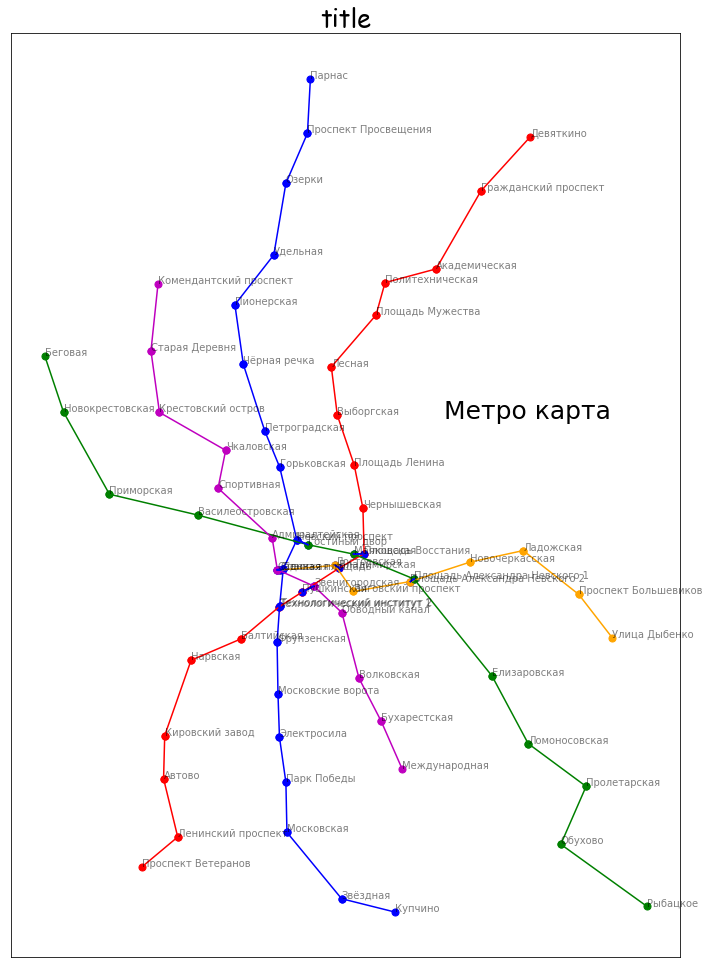

In [27]:
plt.figure(figsize=[12,17])
# plt.scatter(lons, lats, 100, 'r')

for connection in connections_ind:
    st1, st2 = connection
    st1_n, st2_n = stations[st1], stations[st2]
    color = 'b'
    for ind, line in enumerate(lines):
        if st1_n.lower() in line and st2_n.lower() in line:
            color = lines_d[ind]
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color=color)
    plt.scatter([lons[st1], lons[st2]], [lats[st1], lats[st2]], 50, color=color)
    
for inter in inters:
    st1, st2 = inter
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color='b')
    
for ind, station in enumerate(stations):
    plt.text(lons[ind], lats[ind], station, fontsize=10, alpha=0.5)
    
csfont = {'fontname':'Comic Sans MS', 'fontsize' : 25}
hfont = {'fontname':'Helvetica', 'fontsize' : 25}

plt.title('title',**csfont)
plt.text(30.40, 59.97, 'Метро карта', **hfont)
plt.xticks([])
plt.yticks([])
plt.show()

## Анализ, результаты

Повторю вопросы:

- Как часто закрывались в прошлом году какие станции? (quess: центральные и самые конечные чаще всего)
- на сколько минут какая? (quess: от центра по нарастающей, до 1.5 часов)
- сколько между закрытием и постом в телеграме (quess: 5-10)
- максимальное количество закрытых за день? (quess: все или 12)
- сколько раз встречается слово "падение", "футбол", "хоккей", "неисправность"

### Просмотры

Популярность канала:

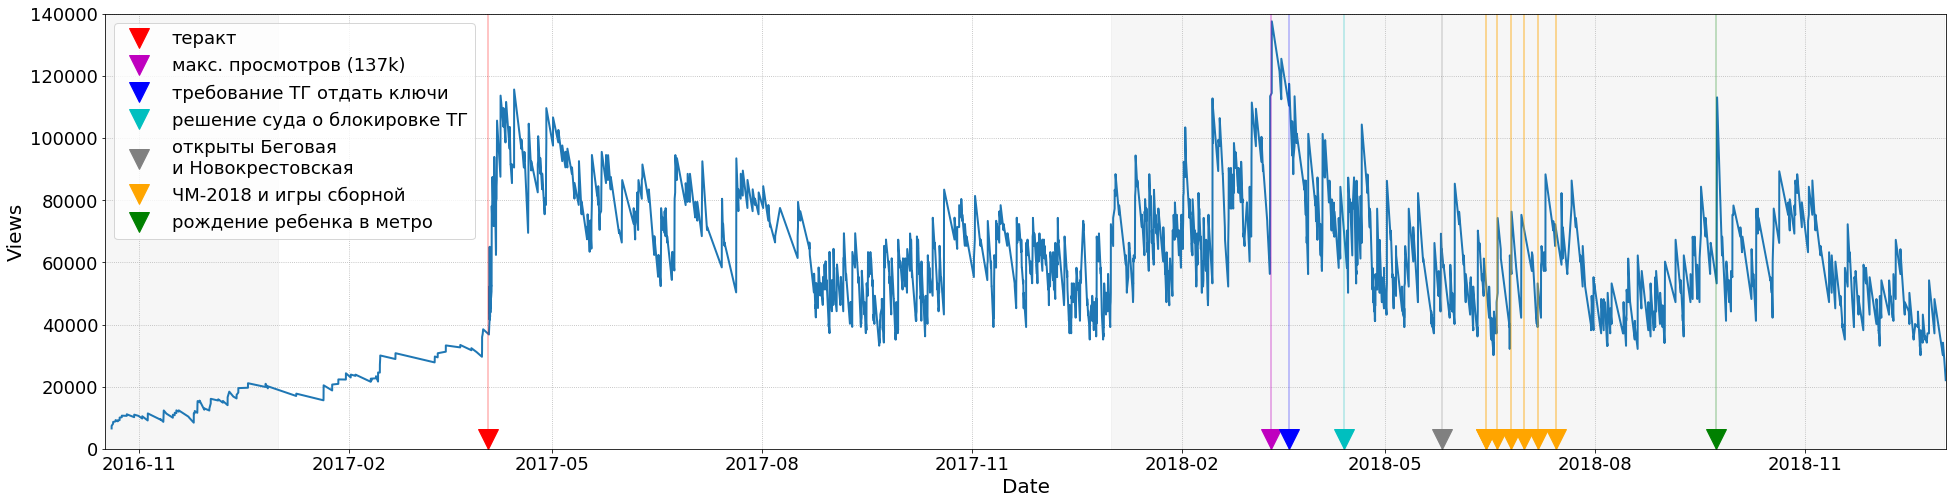

In [162]:
fig = plt.figure(figsize=[33, 8])
plt.plot([pytz.utc.localize(l.date).astimezone(user_timezone) for l in orig_messages], [l.views for l in orig_messages],'-', lw=2)

plt.axvline(x = datetime.date(2017, 4, 3), color = 'r', alpha=0.3) # теракт
plt.plot(datetime.date(2017, 4, 3), 3000, 'v', label='теракт', color='r', ms=20)

# plt.axvline(x = datetime.date(2018, 1, 1), color = 'b', alpha=0.6) # старт нового года
plt.fill_between([datetime.date(2018, 1, 1), datetime.date(2019, 1, 1)], [0, 0], [140000, 140000], color='grey', alpha=0.07)
plt.fill_between([datetime.date(2016, 10, 17), datetime.date(2017, 1, 1)], [0, 0], [140000, 140000], color='grey', alpha=0.07)

plt.axvline(x = datetime.date(2018, 3, 12), color = 'm', alpha=0.4)
plt.plot(datetime.date(2018, 3, 12), 3000, 'v', label='макс. просмотров (137k)', color='m', ms=20)

plt.axvline(x = datetime.date(2018, 3, 20), color = 'b', alpha=0.3)
plt.plot(datetime.date(2018, 3, 20), 3000, 'v', label='требование ТГ отдать ключи', color='b', ms=20)

plt.axvline(x = datetime.date(2018, 4, 13), color = 'c', alpha=0.3)
plt.plot(datetime.date(2018, 4, 13), 3000, 'v', label='решение суда о блокировке ТГ', color='c', ms=20)

plt.axvline(x = datetime.date(2018, 5, 26), color = 'grey', alpha=0.3)
plt.plot(datetime.date(2018, 5, 26), 3000, 'v', label='открыты Беговая \nи Новокрестовская', color='grey', ms=20)


plt.axvline(x = datetime.date(2018, 6, 14), color = 'orange', alpha=0.4, lw=2) # старт ЧМ
# plt.text(datetime.date(2018, 6, 14), 0, 'ЧМ-2018', rotation='30', fontsize=20)
plt.plot(datetime.date(2018, 6, 14), 3000, 'v', label='ЧМ-2018 и игры сборной', color='orange', ms=20)
plt.axvline(x = datetime.date(2018, 6, 19), color = 'orange', alpha=0.4, lw=2) # старт ЧМ
plt.axvline(x = datetime.date(2018, 7, 1), color = 'orange', alpha=0.4, lw=2) # старт ЧМ
plt.axvline(x = datetime.date(2018, 6, 25), color = 'orange', alpha=0.4, lw=2) # старт ЧМ
plt.axvline(x = datetime.date(2018, 7, 7), color = 'orange', alpha=0.4, lw=2) # старт ЧМ

plt.axvline(x = datetime.date(2018, 7, 15), color = 'orange', alpha=0.4, lw=2) # старт ЧМ
# plt.text(datetime.date(2018, 6, 14), 0, 'ЧМ-2018', rotation='30', fontsize=20)
plt.plot([datetime.date(2018, 7, 15), datetime.date(2018, 6, 14), datetime.date(2018, 6, 19), datetime.date(2018, 7, 1), datetime.date(2018, 6, 25), datetime.date(2018, 7, 7)], [3000]*6 , 'v', color='orange', ms=20)


plt.axvline(x = datetime.date(2018, 9, 23), color = 'g', alpha=0.3)
plt.plot(datetime.date(2018, 9, 23), 3000, 'v', label='рождение ребенка в метро', color='g', ms=20)


plt.ylabel('Views', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.grid()
plt.xlim(datetime.date(2016, 10, 17), datetime.date(2019, 1, 2))
plt.ylim(0, 140000)
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation='0', fontsize=18)
plt.setp(ax.get_yticklabels(), rotation='0', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.savefig('./imgs/view_stats2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=400)
plt.show()

Пик в сентябре:

In [62]:
user_timezone = pytz.timezone('Europe/Moscow')
for i in range(0, 320):
    msg = orig_messages[-i]
    if msg.views > 100000:
        print(pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S") + ' ' + msg.message + ' ' + str(msg.views))

2018-09-23 14:24:31 У нас хорошая новость! На ст. Технологический институт в 13.45 родился мальчик 👶 помощь в быстрых родах оказали сотрудники станции. Сейчас малыш и мама в больнице и с ними все хорошо! Это первый метромалыш, который появился на свет в Петербургской  подземке за более полувековую историю! 113138


Максимум просмотров (137607) у совершенно рядового сообщения:

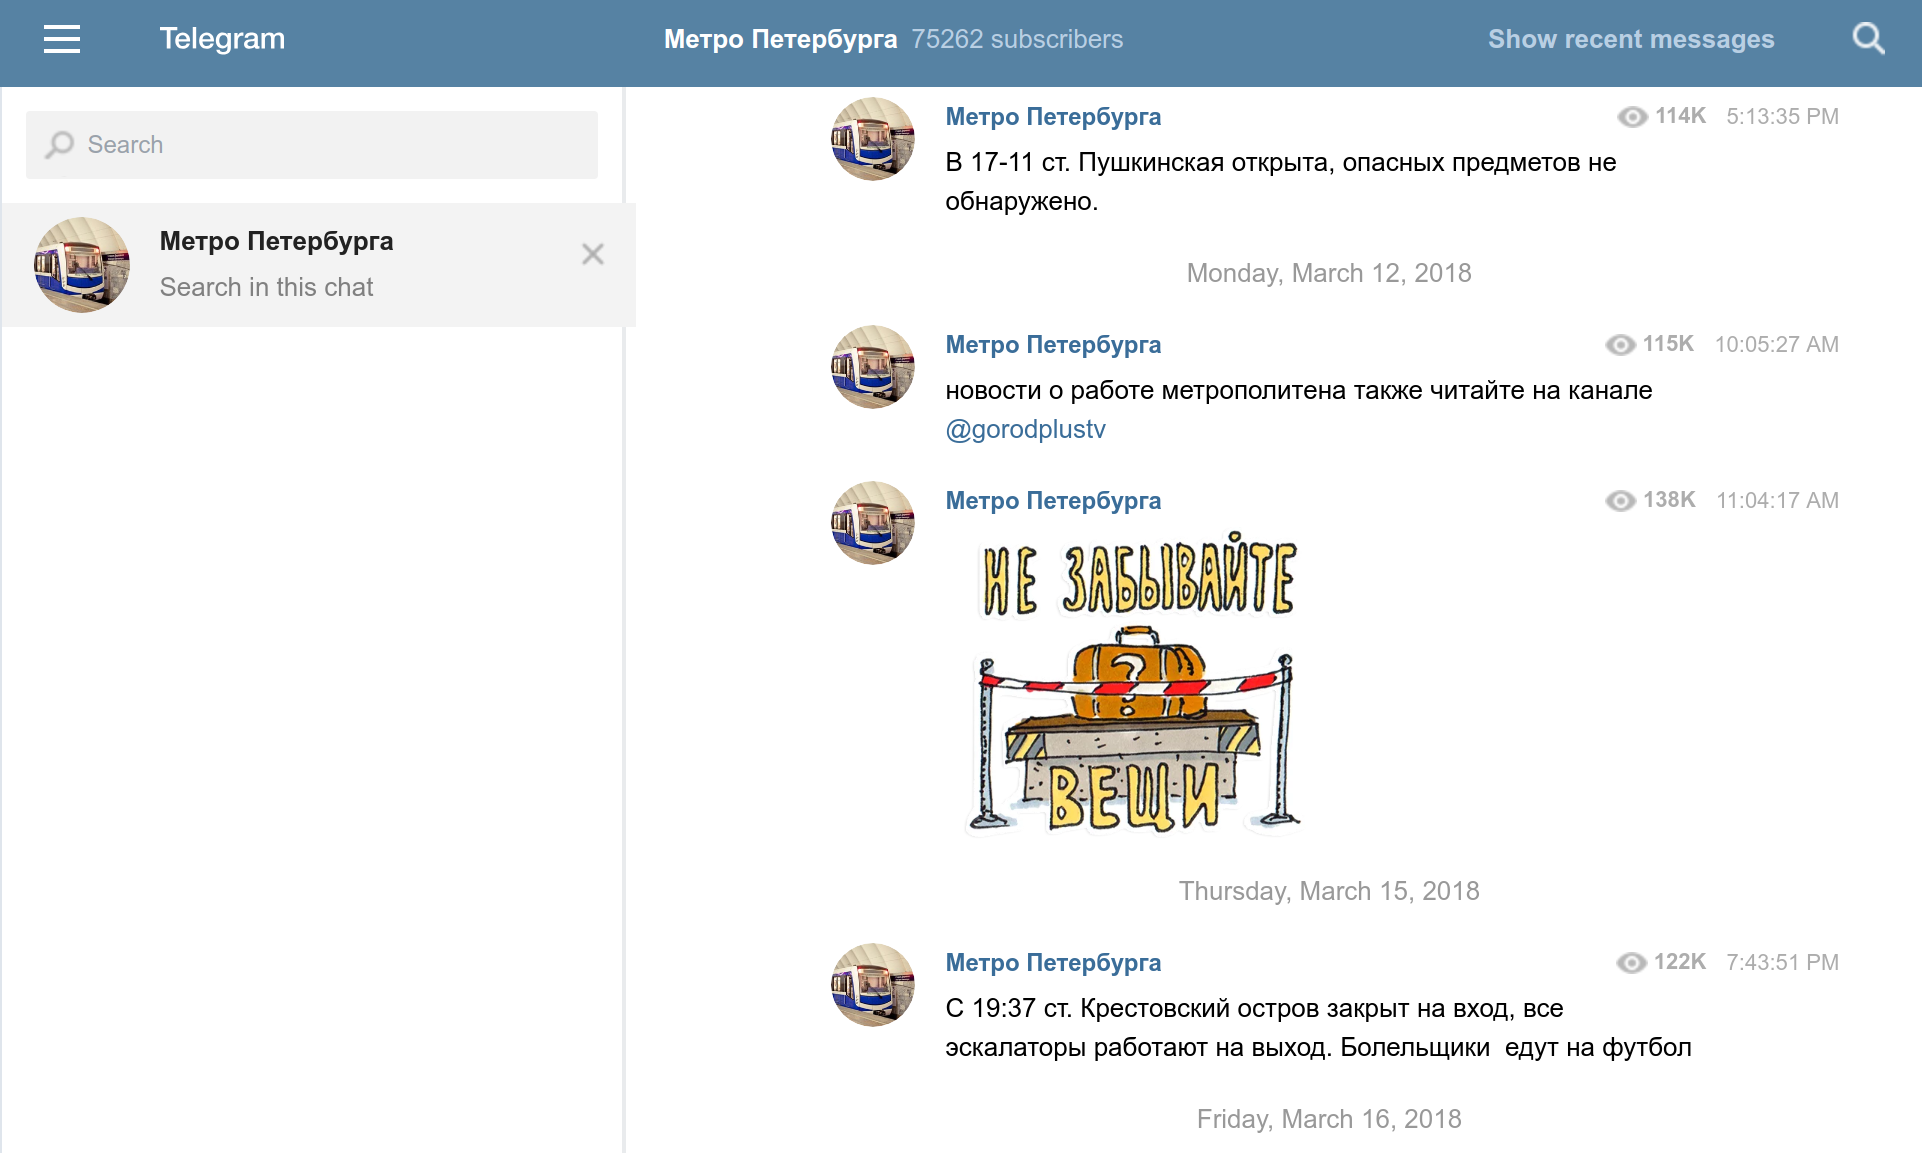

In [81]:
Image('./imgs/max_views.png', width=1000)

Интересно что пики на ЧМ - просто рядовые закрытия без дополнительной инфы.

### Задержка между закрытием и сообщением

сколько между закрытием/событием и постом в телеграме (quess: 5-10)

In [28]:
post_delay = []
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    actual_date = datetime.datetime.strptime(actt, "%Y-%m-%d %H:%M:%S")
#     hour, minute = actual_date.hour, actual_date.minute
    hour, minute = None, None
    if tts:
        try:
            if '.' in tts[0]:
                hour, minute = tts[0].split('.')
            elif '-' in tts[0]:
                hour, minute = tts[0].split('-')
            elif ':' in tts[0]:
                hour, minute = tts[0].split(':')
        except Exception:
            print(tts)
    if hour is not None and minute is not None:
        text_date = actual_date.replace(hour=int(hour), minute=int(minute), second=actual_date.second)
        post_delay.append((actual_date - text_date).total_seconds()/60.)
        
len(post_delay)

861

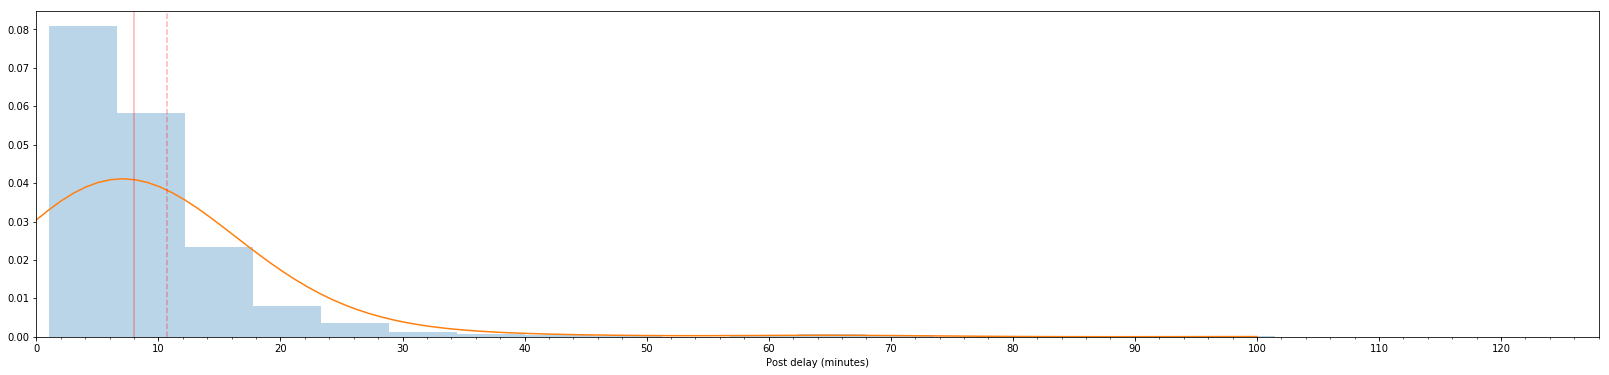

In [32]:
from scipy import stats
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

minorLocator = MultipleLocator(2)
majorLocator = MultipleLocator(10)

post_delay = np.array(post_delay)
post_delay = post_delay[post_delay > 0]

kde = stats.gaussian_kde(post_delay)
xx = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(28,6))
ax.hist(post_delay, normed=True, bins=100, alpha=0.3)
ax.plot(xx, kde(xx))
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)
plt.xlabel('Post delay (minutes)')
plt.axvline(x=np.median(post_delay), ls='-', color='r', alpha=0.3)
plt.axvline(x=np.mean(post_delay), ls='--', color='r', alpha=0.3)
plt.xlim(0, 128)
plt.savefig('./imgs/delay2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=400)
plt.show()

Неплохой результат, стало даже немного меньше чем в 2017.

### Какие закрывались чаще всего

Как часто закрывались в прошлом году какие станции? (quess: центральные и самые конечные чаще всего)

In [33]:
station_mentions = {}
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    for st in sts:
        if st in station_mentions.keys():
            station_mentions[st] += 1
        else:
            station_mentions[st] = 1

In [34]:
for k, v in sorted(station_mentions.items(), key=lambda l: (l[1],l[0]), reverse=True): print(k, v)

Площадь Восстания 80
Гостиный двор 70
Невский проспект 68
Маяковская 55
Удельная 37
Звенигородская 35
Пушкинская 32
Достоевская 32
Гражданский проспект 31
Владимирская 30
Горьковская 27
Чернышевская 26
Озерки 26
Сенная площадь 25
Пионерская 25
Петроградская 25
Комендантский проспект 24
Старая Деревня 23
Проспект Просвещения 23
Проспект Ветеранов 23
Технологический институт 1 22
Площадь Ленина 22
Площадь Александра Невского 2 22
Площадь Александра Невского 1 22
Рыбацкое 21
Приморская 21
Новочеркасская 21
Технологический институт 2 20
Садовая 20
Лиговский проспект 20
Спасская 19
Крестовский остров 19
Девяткино 19
Ладожская 18
Пролетарская 17
Елизаровская 16
Василеостровская 15
Беговая 15
Автово 14
Нарвская 12
Звёздная 12
Бухарестская 12
Адмиралтейская 12
Чёрная речка 11
Ломоносовская 11
Спортивная 9
Площадь Мужества 9
Купчино 9
Выборгская 9
Академическая 9
Электросила 8
Улица Дыбенко 8
Парнас 8
Московская 8
Международная 8
Лесная 8
Ленинский проспект 8
Обводный канал 7
Новокрестовская 7


Тут надо делить на два, но для карты это не важно.

Карта:

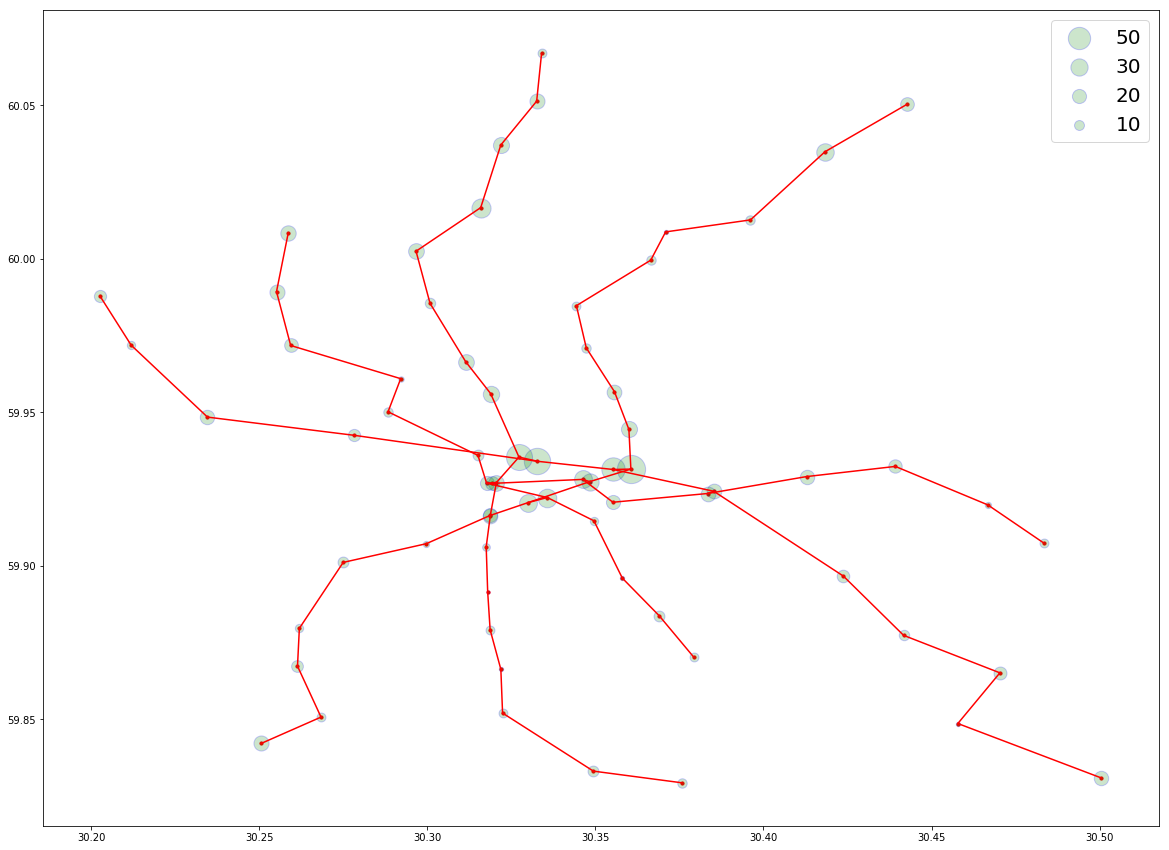

In [48]:
plt.figure(figsize=[20,15])
plt.scatter(lons, lats, 10, 'r')
for connection in connections_ind:
    st1, st2 = connection
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color='r')
    
for ind,station in enumerate(stations):
    if station in station_mentions.keys():
        plt.scatter(lons[ind], lats[ind], 10*station_mentions[station], 'g', edgecolor='b', alpha=0.2)

ax = plt.gca()
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
        
plt.scatter([30.],[58.],[50*10], 'g', edgecolor='b', alpha=0.2, label='50')
plt.scatter([30.],[58.],[30*10], 'g', edgecolor='b', alpha=0.2, label='30')
plt.scatter([30.],[58.],[20*10], 'g', edgecolor='b', alpha=0.2, label='20')
plt.scatter([30.],[58.],[10*10], 'g', edgecolor='b', alpha=0.2, label='10')
plt.legend(fontsize=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
        
plt.savefig('./imgs/mentions2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)
plt.show()

Про крайние я не угадал, а про центр и так понятно.

*На самом деле это упоминания, а не точное число, но связь думаю самая прямая.*

### На сколько закрывались

на сколько минут какая? (quess: от центра по нарастающей, до 1.5 часов)

In [49]:
def get_text_time(actt, tts):
    actual_date = datetime.datetime.strptime(actt, "%Y-%m-%d %H:%M:%S")
    hour, minute = actual_date.hour, actual_date.minute
    if tts:
        try:
            if '.' in tts[0]:
                hour, minute = tts[0].split('.')
            elif '-' in tts[0]:
                hour, minute = tts[0].split('-')
            elif ':' in tts[0]:
                hour, minute = tts[0].split(':')
        except Exception:
            print(tts)
    if hour is not None and minute is not None:
        text_date = actual_date.replace(hour=int(hour), minute=int(minute), second=actual_date.second)
    return actual_date, text_date

In [50]:
closed_time = []
for station in stations:
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)
    
    if station_messages == []:
        print(station)
        continue
    
    status_sum = ''          
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    status = ''
    
    print(station_messages)
    
    for i in range(len(station_messages)):
        tts, stat, actt, text, _ = station_messages[i]
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
        
        print('-'*20)
        print(tts, stat, actt, text, _, date)
        print(actual_date.date(),date.date())
        
        if actual_date.date() == date.date() or actual_date.date() == (date - datetime.timedelta(hours=1)).date():
            msg = station_messages[i]
            if msg[1] == 'CLOSE':
                status_sum = status_sum + 'C'
            elif msg[1] == 'OPEN':
                if status_sum:
                    if status_sum[-1] == 'C':
                        status_sum = status_sum[:-1]
                        print('APPEND')
                        tts1, stat1, actt1, text1, i1 = station_messages[i-1]
                        print(tts1, stat1, actt1, text1, i1)
                        closed_time.append([station, get_text_time(actt1,tts1)[1], get_text_time(actt,tts)[1]])
#                         if (get_text_time(actt,tts)[1]-get_text_time(actt1,tts1)[1]).total_seconds()/60. > 250:
#                             print(actt,tts,actt1,tts1)
                    else:
                        status_sum = status_sum + 'O'
                else:
                    status_sum = status_sum + 'O'
        else:
            print('+')
            actual_date = date
            if status_sum:
                status = status + '|' + status_sum
            status_sum = 'C' if station_messages[i][1] == 'CLOSE' else 'O'

[[['21-58'], 'CLOSE', '2018-01-08 22:05:11', 'В 21-58 ст  Автово закрыта из-за бесхозного предмета', 17], [['22-49'], 'OPEN', '2018-01-08 22:52:05', 'В 22-49 ст  Автово открыта.', 18], [['22-53'], 'CLOSE', '2018-01-27 22:56:45', 'В 22-53 ст  Автово закрыта в связи с обнаружением бесхозного предмета.', 105], [['22-59'], 'OPEN', '2018-01-27 23:01:08', 'В 22-59 ст  Автово открыта.', 106], [['20-48', '20-51'], 'CLOSE', '2018-02-09 20:57:14', 'В 20-48 ст  Автово закрыта в связи с обнаружением бесхозного предмета и в  20-51 ст  Пушкинская закрыта.', 174], [['21-35'], 'OPEN', '2018-02-09 21:40:41', 'В 21-35  ст  Автово открыта, опасных предметов не обнаружено.', 176], [['18-25'], 'CLOSE', '2018-04-10 18:27:46', 'В 18-25 ст  Автово закрыта на проверку.', 355], [['19:03'], 'OPEN', '2018-04-10 19:08:18', 'В 19:03 ст  Автово открыта.', 357], [[], 'OPEN', '2018-04-18 14:01:51', 'На Линии 1 открыты станции Автово, Технологический институт, Площадь Восстания и участок Площадь Ленина - Девяткино', 39

--------------------
['23-32'] OPEN 2018-01-28 23:34:27 В 23-32 ст  Гражданский пр  открыта, опасных предметов не обнаружено. 113 2018-01-28 23:34:27
2018-01-28 2018-01-28
APPEND
['22-45'] CLOSE 2018-01-28 22:56:47 В 22-45 ст  Гражданский пр  закрыта в связи с обнаружением бесхозного предмета. 112
--------------------
['07-45'] CLOSE 2018-02-12 07:57:53 В 07-45 ст  Гражданский пр  закрыта в связи с обнаружением бесхозного предмета на платформе. 191 2018-02-12 07:57:53
2018-01-28 2018-02-12
+
--------------------
['08-53'] OPEN 2018-02-12 08:58:42 В 08-53 ст  Гражданский пр  открыта. 192 2018-02-12 08:58:42
2018-02-12 2018-02-12
APPEND
['07-45'] CLOSE 2018-02-12 07:57:53 В 07-45 ст  Гражданский пр  закрыта в связи с обнаружением бесхозного предмета на платформе. 191
--------------------
['19-20'] CLOSE 2018-02-23 19:27:10 В 19-20 ст  Гражданский пр   закрыта в связи с обнаружением бесхозного предмета. 235 2018-02-23 19:27:10
2018-02-12 2018-02-23
+
--------------------
['20-28'] OPEN 20

['14-57'] CLOSE 2018-10-10 15:08:25 В 14-57 ст  Крестовский остров закрыта из-за бесхозного предмета 867
[[['21-50'], 'CLOSE', '2018-01-16 22:03:08', 'В 21-50 ст  Купчино закрыта на вход, на выход работает.', 50], [['22-06'], 'OPEN', '2018-01-16 22:09:28', 'В 22-06 ст  Купчино открыта, хозяин пакета нашёлся.', 51], [['20-20'], 'OPEN', '2018-01-28 20:26:31', 'В 20-20 ст  Купчино открыта.', 111]]
--------------------
['21-50'] CLOSE 2018-01-16 22:03:08 В 21-50 ст  Купчино закрыта на вход, на выход работает. 50 2018-01-16 22:03:08
2018-01-28 2018-01-16
+
--------------------
['22-06'] OPEN 2018-01-16 22:09:28 В 22-06 ст  Купчино открыта, хозяин пакета нашёлся. 51 2018-01-16 22:09:28
2018-01-16 2018-01-16
APPEND
['21-50'] CLOSE 2018-01-16 22:03:08 В 21-50 ст  Купчино закрыта на вход, на выход работает. 50
--------------------
['20-20'] OPEN 2018-01-28 20:26:31 В 20-20 ст  Купчино открыта. 111 2018-01-28 20:26:31
2018-01-16 2018-01-28
+
[[['22-06'], 'CLOSE', '2018-01-07 22:15:34', 'В 22-06 

2018-06-17 2018-06-29
+
--------------------
['19-47'] OPEN 2018-06-29 19:54:56 В 19-47 ст  Невский пр и переход на ст  Гостиный двор открыты. 638 2018-06-29 19:54:56
2018-06-29 2018-06-29
APPEND
['19-21'] CLOSE 2018-06-29 19:29:18 С 19-21 ст  Невский пр  и переход на ст  Гостиный двор закрыты в связи обнаружением бесхозного предмета на платформе. 636
--------------------
['22-50'] CLOSE 2018-07-19 23:00:17 В 22-50 ст  Гостиный двор и переход на ст  Невский пр закрыты  в связи с обнаружением бесхозного предмета. 672 2018-07-19 23:00:17
2018-06-29 2018-07-19
+
--------------------
['23-34'] OPEN 2018-07-19 23:37:02 В 23-34 ст  Гостиный двор и переход на ст  Невский пр  открыты, опасных предметов не обнаружено. 673 2018-07-19 23:37:02
2018-07-19 2018-07-19
APPEND
['22-50'] CLOSE 2018-07-19 23:00:17 В 22-50 ст  Гостиный двор и переход на ст  Невский пр закрыты  в связи с обнаружением бесхозного предмета. 672
--------------------
['14:42'] CLOSE 2018-08-06 14:56:18 В 14:42 ст  Гостиный дво

['20-33'] OPEN 2018-11-27 20:35:29 В 20-33 ст  пл  Восстания 1,2 и переход на ст  Маяковская открыты. 963 2018-11-27 20:35:29
2018-11-27 2018-11-27
APPEND
['19-43'] CLOSE 2018-11-27 19:57:23 В 19-43 ст  пл  Восстания 1 и 2 и переход закрыты в связи с обнаружением бесхозного предмета. 962
--------------------
['07-58'] CLOSE 2018-12-19 08:16:31 В 07-58 ст  Маяковская и переход на ст  пл  Восстания закрыты в связи с обнаружением бесхозного предмета. 1011 2018-12-19 08:16:31
2018-11-27 2018-12-19
+
--------------------
['08-19'] OPEN 2018-12-19 08:20:25 В 08-19 ст  Маяковская и переход на ст  пл  Восстания открыты. 1012 2018-12-19 08:20:25
2018-12-19 2018-12-19
APPEND
['07-58'] CLOSE 2018-12-19 08:16:31 В 07-58 ст  Маяковская и переход на ст  пл  Восстания закрыты в связи с обнаружением бесхозного предмета. 1011
--------------------
['15:15'] CLOSE 2018-12-21 15:25:32 В 15:15 ст  пл  Восстания и переход на ст  Маяковская закрыты в связи обнаружением бесхозного предмета 1018 2018-12-21 15:

['15-30'] OPEN 2018-02-08 15:34:10 С 15-30 ст  Сенная площадь работает в обычном режиме 166 2018-02-08 15:34:10
2018-02-08 2018-02-08
APPEND
['13-49'] CLOSE 2018-02-08 13:56:45 В 13-49 ст  Сенная площадь закрыта на вход, на выход работает 165
--------------------
['14-12'] CLOSE 2018-02-17 14:22:15 В 14-12 ст Сенная  и переходы закрыты в связи с обнаружением бесхозного предмета на платформе. 214 2018-02-17 14:22:15
2018-02-08 2018-02-17
+
--------------------
['14-50'] OPEN 2018-02-17 14:54:05 В 14-50 ст  Сенная открыта, опасных предметов не обнаружено. 215 2018-02-17 14:54:05
2018-02-17 2018-02-17
APPEND
['14-12'] CLOSE 2018-02-17 14:22:15 В 14-12 ст Сенная  и переходы закрыты в связи с обнаружением бесхозного предмета на платформе. 214
--------------------
['09-29'] CLOSE 2018-04-03 09:54:12 С 09-29 ст  Садовая и переходы на ст  Спасская и Сенная площадь закрыты из-за бесхозного предмета 326 2018-04-03 09:54:12
2018-02-17 2018-04-03
+
--------------------
['15:34'] CLOSE 2018-07-25 1

['14-11'] CLOSE 2018-02-07 14:18:00 В 14-11 ст  Удельная закрыта из-за бесхозного предмета 156
--------------------
['11-03'] CLOSE 2018-02-12 11:16:28 В 11-03 ст  Удельная закрыта из-за обнаружения бесхозного предмета. 193 2018-02-12 11:16:28
2018-02-07 2018-02-12
+
--------------------
['12-10'] OPEN 2018-02-12 12:11:18 В 12-10 ст  Удельная открыта. 194 2018-02-12 12:11:18
2018-02-12 2018-02-12
APPEND
['11-03'] CLOSE 2018-02-12 11:16:28 В 11-03 ст  Удельная закрыта из-за обнаружения бесхозного предмета. 193
--------------------
['17-37'] CLOSE 2018-02-12 17:46:36 В 17-37 ст  Удельная закрыта с связи с обнаружением бесхозного предмета в вестибюле (рюкзак). 203 2018-02-12 17:46:36
2018-02-12 2018-02-12
--------------------
['18-28'] OPEN 2018-02-12 18:30:21 В 18-28 ст  Удельная открыта. 204 2018-02-12 18:30:21
2018-02-12 2018-02-12
APPEND
['17-37'] CLOSE 2018-02-12 17:46:36 В 17-37 ст  Удельная закрыта с связи с обнаружением бесхозного предмета в вестибюле (рюкзак). 203
---------------

In [51]:
closed_time

[['Автово',
  datetime.datetime(2018, 1, 8, 21, 58, 11),
  datetime.datetime(2018, 1, 8, 22, 49, 5)],
 ['Автово',
  datetime.datetime(2018, 1, 27, 22, 53, 45),
  datetime.datetime(2018, 1, 27, 22, 59, 8)],
 ['Автово',
  datetime.datetime(2018, 2, 9, 20, 48, 14),
  datetime.datetime(2018, 2, 9, 21, 35, 41)],
 ['Автово',
  datetime.datetime(2018, 4, 10, 18, 25, 46),
  datetime.datetime(2018, 4, 10, 19, 3, 18)],
 ['Адмиралтейская',
  datetime.datetime(2018, 4, 2, 20, 10, 23),
  datetime.datetime(2018, 4, 2, 21, 6, 58)],
 ['Адмиралтейская',
  datetime.datetime(2018, 6, 12, 12, 7, 34),
  datetime.datetime(2018, 6, 12, 12, 40, 22)],
 ['Адмиралтейская',
  datetime.datetime(2018, 8, 30, 16, 48, 8),
  datetime.datetime(2018, 8, 30, 17, 30, 57)],
 ['Адмиралтейская',
  datetime.datetime(2018, 9, 27, 12, 10, 52),
  datetime.datetime(2018, 9, 27, 12, 34, 36)],
 ['Адмиралтейская',
  datetime.datetime(2018, 12, 7, 22, 58, 49),
  datetime.datetime(2018, 12, 7, 23, 38, 8)],
 ['Академическая',
  datetim

In [52]:
len(closed_time)

426

In [53]:
closed_time_s = np.array([(l[2]-l[1]).total_seconds()/60. for l in closed_time])

In [54]:
closed_time_s = sorted(closed_time_s)

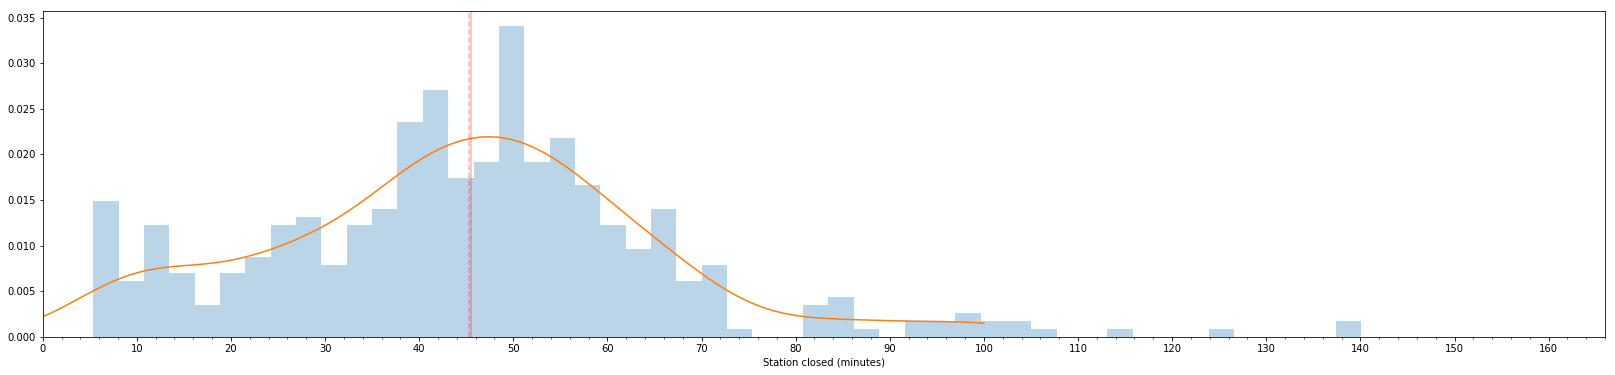

In [55]:
from scipy import stats
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

minorLocator = MultipleLocator(2)
majorLocator = MultipleLocator(10)

kde = stats.gaussian_kde(closed_time_s[:-1])
xx = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(28,6))
ax.hist(closed_time_s[:-1], normed=True, bins=50, alpha=0.3)
ax.plot(xx, kde(xx))
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)
plt.xlabel('Station closed (minutes)')
plt.axvline(x=np.median(closed_time_s[:-1]), ls='-', color='r', alpha=0.3)
plt.axvline(x=np.mean(closed_time_s[:-1]), ls='--', color='r', alpha=0.3)
plt.xlim(0,166)
plt.savefig('./imgs/closedtime2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)
plt.show()

В среднем стали на большее время закрывать, бимодальность почти исчезла.

Попробуем нормальную карту нарисовать:

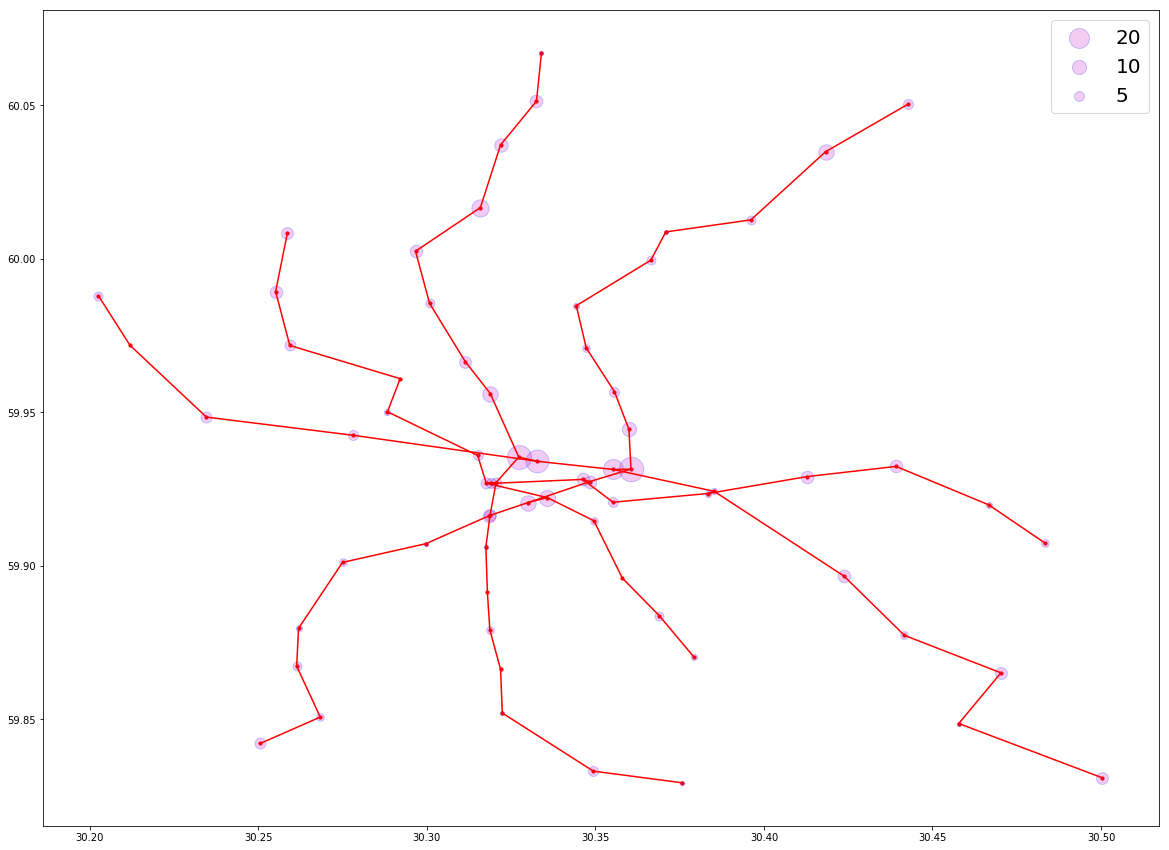

In [65]:
station_closes = {}

for station in stations:
    station_closes[station] = 0

for ind, entity in enumerate(closed_time):
    sts, _1,_2 = entity
    station_closes[sts] += 1

plt.figure(figsize=[20,15])
plt.scatter(lons, lats, 10, 'r')
for connection in connections_ind:
    st1, st2 = connection
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color='r')

multipl = 20
    
for ind,station in enumerate(stations):
    if station in station_mentions.keys():
        plt.scatter(lons[ind], lats[ind], multipl*station_closes[station], 'm', edgecolor='b', alpha=0.2)

ax = plt.gca()
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
        
# plt.scatter([30.],[58.],[50*multipl], 'g', edgecolor='b', alpha=0.2, label='50')
# plt.scatter([30.],[58.],[30*multipl], 'g', edgecolor='b', alpha=0.2, label='30')
plt.scatter([30.],[58.],[20*multipl], 'm', edgecolor='b', alpha=0.2, label='20')
plt.scatter([30.],[58.],[10*multipl], 'm', edgecolor='b', alpha=0.2, label='10')
plt.scatter([30.],[58.],[5*multipl], 'm', edgecolor='b', alpha=0.2, label='5')
plt.legend(fontsize=20)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
        
plt.savefig('./imgs/frequency2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)
plt.show()

В целом повторяет карту упоминаний, но проверим:

In [67]:
corr_data = []
for station in stations:
    cl = station_closes[station]
    mt = station_mentions[station]
    corr_data.append((cl,mt))

cl,mt = zip(*corr_data)
print(np.corrcoef(cl,mt)[0,1])

0.9646760734947103


Коэффициент корреляции 0.96, т.е. очень даже соответствует (оно и понятно, в основном пишут про закрытие и открытие). Значит в прошлом году карта была не такая уж и бесполезная.

### Максимум закрыто за день раз

Сколько максимум было закрыто (раз, т.е. одна станция может считаться больше одного раза) в день?

In [68]:
closed_per_day = {}
for st, ct, ot in closed_time:
    date = ct.date()
    if date in closed_per_day.keys():
        closed_per_day[date] += 1
    else:
        closed_per_day[date] = 1

In [69]:
closed_per_day = sorted(closed_per_day.items())

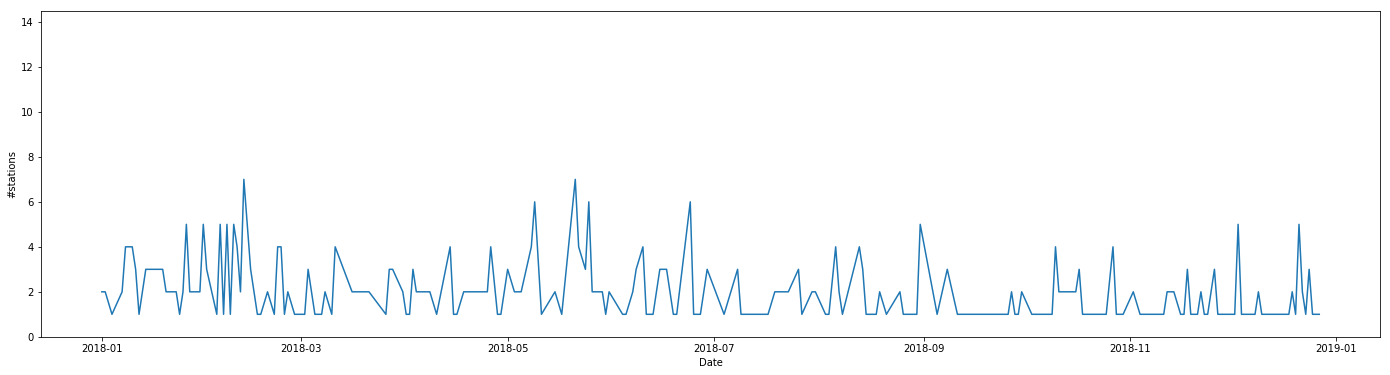

In [76]:
fig = plt.figure(figsize=[24, 6])
plt.plot(list(zip(*closed_per_day))[0], list(zip(*closed_per_day))[1], '-')
# plt.axvline(x = datetime.date(2017, 4, 3), color = 'r', alpha=0.3)
plt.ylabel('#stations')
plt.xlabel('Date')
plt.ylim(0, 14.5)
plt.savefig('./imgs/closedperday2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)
plt.show()

Меньше, чем в 2018. Всего дней когда что-нибудь не закрывалось:

In [81]:
365-len(list(zip(*closed_per_day))[0])

154

А по количеству:

In [82]:
np.unique(list(zip(*closed_per_day))[1], return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]), array([100,  55,  28,  15,   8,   3,   2]))

### Время закрытия

В какие часы чаще всего закрываются:

In [83]:
sample_date = datetime.datetime.now()
sample_dates = []
for st, ct, ot in closed_time:
    s_date = sample_date.replace(hour=ct.hour, minute=ct.minute, second=ct.second)
    sample_dates.append(s_date)

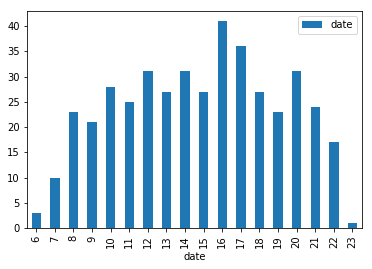

In [84]:
df = pd.DataFrame(data=sample_dates, columns=['date'])
df.groupby(df["date"].dt.hour).count().plot(kind="bar")
plt.savefig('./imgs/closehour2018.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)
plt.show()

Ничего не изменилось.

### Другие причины

сколько раз встречается слово "падение", "футбол", "хоккей", "неисправность"

In [85]:
fulltext = ' '.join(corpora)

In [86]:
for word in ["паден", "футбол", "хоккей", "неисправн"]:
    print(word + ' : ' + str(fulltext.count(word)))

паден : 2
футбол : 5
хоккей : 1
неисправн : 8


In [87]:
from collections import Counter
words = re.findall('\w+', fulltext.lower())
Counter(words).most_common(20)

[('ст', 1260),
 ('в', 1095),
 ('бесхозного', 369),
 ('предмета', 368),
 ('не', 345),
 ('предметов', 343),
 ('обнаружено', 338),
 ('опасных', 335),
 ('на', 303),
 ('закрыта', 297),
 ('открыта', 287),
 ('и', 255),
 ('с', 252),
 ('м', 250),
 ('связи', 218),
 ('автобус', 210),
 ('обнаружением', 201),
 ('за', 171),
 ('из', 168),
 ('переход', 164)]

Тут конечно надо бы нормализацию провести само собой, но кажется что ничего интересного все равно не найти (может tf-idf, но не сильно интересно).

Отдельно упомянуть ЧМ:

In [94]:
fulltext.count('болельщ'), fulltext.count('чемп'), fulltext.count('ЧМ'), fulltext.count('ЧМ')

(1, 0, 0)